In [1]:
import numpy as np
import pandas as pd
import mplfinance as mpf
import os
from glob import glob
import matplotlib.pyplot as plt

%matplotlib inline

#import talib as ta # conda activate cryt310
from matplotlib.ticker import AutoMinorLocator
import time
from itertools import zip_longest
from IPython.display import Javascript
import datetime
import schedule
import json,requests 

%load_ext autoreload
%autoreload 2

tickerpair="ETCUSDT" #GBPUSDT #LTCUSDT #ETHUSDT #BTCUSDT
#tickerpair="BNBUSDT" #BNBUSDT #AUDUSDT #XMRUSDT
intervals=['1m','3m','5m','15m','30m','1h','2h','3h','4h','6h','8h','12h','1d','3d','1w','1Month']

# define constants
tickerpair="ETCUSDT"
interval="1m"
from aver6_funcs import get_data
import pickle,tqdm
from concurrent.futures import ThreadPoolExecutor
import concurrent

In [2]:
with open("9_0_subset_symbols_24hrchange.pkl","rb") as f:
    subset_symbols = pickle.load(f)[:1] # select the top 50 symbols
len(subset_symbols),subset_symbols[0]

(1, 'BTC')

In [3]:
top50symbols_usdt = [s+"USDT" for s in subset_symbols[:1]]

In [4]:
dfmpl_list_list = []
for iterr in tqdm.tqdm(range(1050)):
    with open(f"2_3_1_analysisdata/2_3_1_dfmpl_list_{iterr:05d}.pkl","rb")as f:
        dfmpl_list2 = pickle.load(f)
    dfmpl_list = [ d for d in dfmpl_list2 if d[1] in top50symbols_usdt]
    dfmpl_list_list.append( dfmpl_list.copy())

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1050/1050 [00:06<00:00, 157.82it/s]


In [5]:
%%time
for symm in tqdm.tqdm(subset_symbols):
    if "USD" in symm: continue
    symm = symm+"USDT"
    df_  = pd.concat([ df for dfll in dfmpl_list_list[::-1] for df,sym,idd in dfll if sym==symm])
    idx = np.unique( df_.index.values, return_index = True )[1]
    df__ = df_.iloc[idx]
    if not all(np.diff(df__.index,2).astype(float)==0):
        print(symm)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.77it/s]

BTCUSDT
CPU times: total: 109 ms
Wall time: 178 ms


# concat the dfs, store into a list of dfs, also store a list of corresponding symbols

In [6]:
dfmpl_list = []

for idd,symm in enumerate(tqdm.tqdm(subset_symbols)):
    #if idd<110:continue
    if "USD" in symm: continue
    symm = symm+"USDT"
    df_  = pd.concat([ df for dfll in dfmpl_list_list[::-1] for df,sym,idd in dfll if sym==symm])
    
    idx = np.unique( df_.index.values, return_index = True )[1]
    df__ = df_.iloc[idx]
    dfmpl_list.append( (df__.copy(),symm,idd) ) 

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.33it/s]


In [7]:
dfmpl,symm,idd = dfmpl_list[0]
dfmpl,symm,idd,len(dfmpl_list)

(                         Open      High       Low     Close    Volume
 Date                                                                 
 2022-01-15 09:34:00  43023.60  43063.12  43022.02  43061.91  18.18252
 2022-01-15 09:35:00  43061.92  43061.92  43051.10  43052.05   8.86614
 2022-01-15 09:36:00  43052.05  43055.74  43020.30  43024.76  16.04007
 2022-01-15 09:37:00  43024.76  43024.77  43004.35  43008.39  10.07169
 2022-01-15 09:38:00  43008.39  43009.99  42977.00  42977.00  16.83826
 ...                       ...       ...       ...       ...       ...
 2024-01-14 13:29:00  42737.46  42740.00  42724.00  42739.99   7.93961
 2024-01-14 13:30:00  42740.00  42746.00  42739.99  42746.00   6.90809
 2024-01-14 13:31:00  42745.99  42746.00  42732.24  42732.24   6.75295
 2024-01-14 13:32:00  42732.25  42737.25  42732.24  42737.24   5.12337
 2024-01-14 13:33:00  42737.25  42737.25  42735.20  42735.21   5.44117
 
 [1049920 rows x 5 columns],
 'BTCUSDT',
 0,
 1)

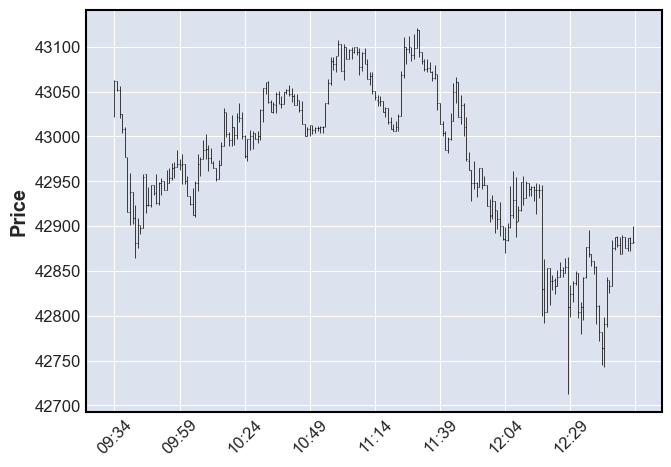

In [8]:
mpf.plot(dfmpl.iloc[:200])

In [9]:
import pandas_ta as ta
import talib
from talib import MA_Type

In [10]:
def find_ones_with_min_distance(data, min_distance=1):
    ones_positions = []
    last_one = -min_distance - 1

    for i, value in enumerate(data):
        if value == 1:
            if i - last_one >= min_distance:
                ones_positions.append(i)
                last_one = i

    return ones_positions
 


In [11]:
%%time
upper30, middle30, lower30 = talib.BBANDS(dfmpl.Close,timeperiod=30, matype=MA_Type.T3)
upper15, middle15, lower15 = talib.BBANDS(dfmpl.Close,timeperiod=15, matype=MA_Type.T3)
#upper, middle, lower = talib.BBANDS(dfmpl.Close,timeperiod=5, nbdevup=2, nbdevdn=2, matype=MA_Type.T3)
sma20 =  talib.SMA(dfmpl.Close,timeperiod=50)
change = ((dfmpl.Close-dfmpl.Open)/dfmpl.Open).rolling(4).mean()
momentum = talib.MOM(dfmpl.Close,timeperiod=40)
momentum_rolling30 = momentum.rolling(30).mean()
momentum_rolling40 = momentum.rolling(40).mean()
stoRSI_fastk,stoRSI_fastd = talib.STOCHRSI(dfmpl.Close,timeperiod=30,fastk_period=25,fastd_period=15)

CPU times: total: 266 ms
Wall time: 267 ms


In [ ]:
bbp30 = np.clip((np.clip((dfmpl.Close-middle30)/(upper30-lower30),-5,5)+2)/4,0,1)
bbp15 = np.clip((np.clip((dfmpl.Close-middle15)/(upper15-lower15),-5,5)+2)/4,0,1)

In [63]:
%%time
vals = np.clip((np.clip((dfmpl.Close-middle30)/(upper30-lower30),-5,5)+2)/4,0,1)
vals = vals.values
vals = vals[np.isfinite(vals)]

CPU times: total: 31.2 ms
Wall time: 81.5 ms


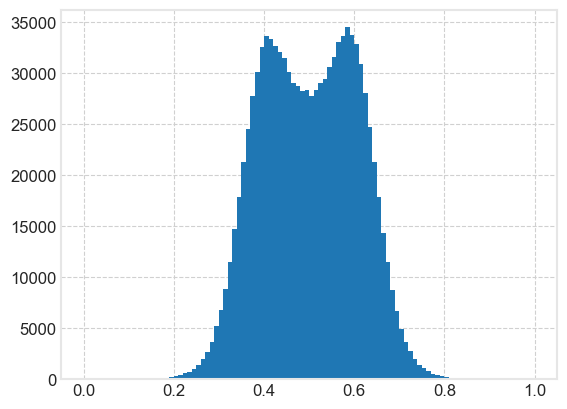

In [64]:
plt.hist(vals,bins=100); 

In [13]:
mfi = talib.MFI(dfmpl.High,dfmpl.Low,dfmpl.Close,dfmpl.Volume,20)

In [73]:
%%time
binary_condition = (momentum<-450) #& (momentum_rolling30<-250) & (momentum_rolling30.shift(30)<50) & ( momentum_rolling30 <momentum_rolling40)
potential_candidates = np.where(binary_condition)[0]
#potential_candidates = np.where(change<-0.002)[0]
#potential_candidates

CPU times: total: 0 ns
Wall time: 1.99 ms


In [74]:
potential_candidates = find_ones_with_min_distance(binary_condition,40)

In [75]:
dd_ = (dfmpl.iloc[-1].name-dfmpl.iloc[0].name).total_seconds()/3600/24
f"{dd_/len(potential_candidates):.4f} days per trade, {len(potential_candidates)} trades in {dd_:.0f} days"

'1.0932 days per trade, 667 trades in 729 days'

In [76]:
len(potential_candidates),len(potential_candidates[::27])

(667, 25)

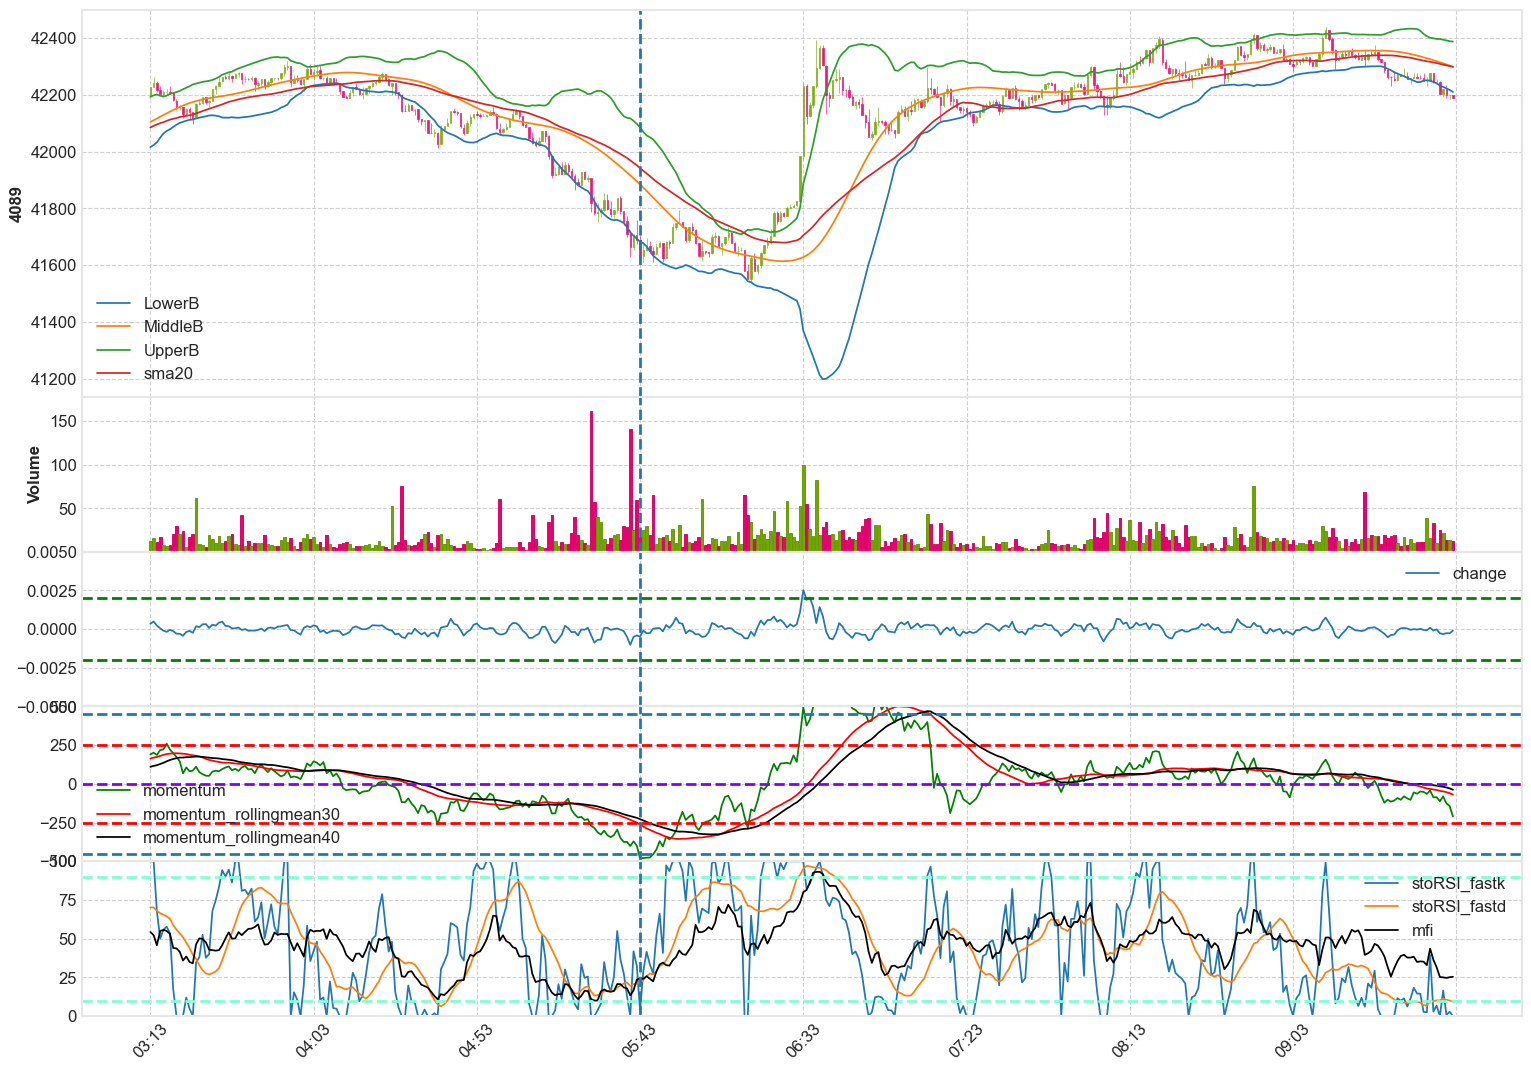

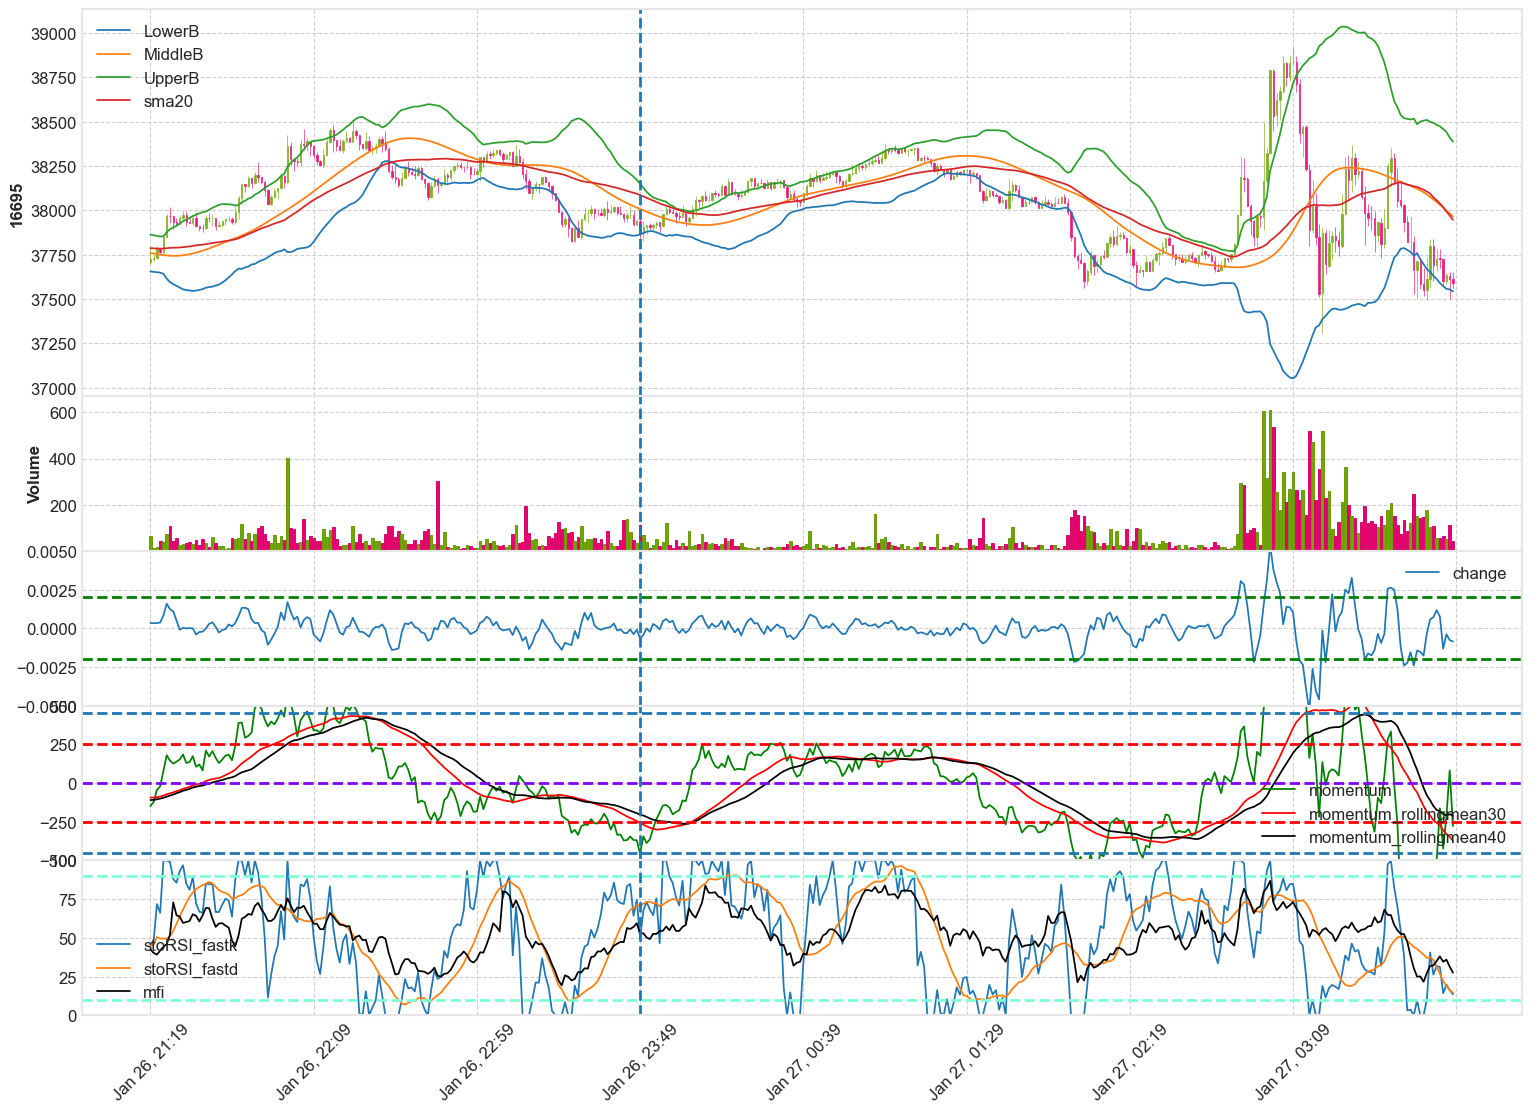

CPU times: total: 3.39 s
Wall time: 4.26 s


In [18]:
%%time
for inddex_of_frame in potential_candidates[:31:27]:
    #vlines=dict(vlines=[dfmpl.iloc[inddex_of_frame].name])
    my_vlines=[dfmpl.iloc[inddex_of_frame].name]
    my_vlines=[150]
    lowerlim = inddex_of_frame-150
    upperlim = lowerlim+400
    apdict = [mpf.make_addplot(lower30.iloc[lowerlim:upperlim],label="LowerB"),
              mpf.make_addplot(middle30.iloc[lowerlim:upperlim],label="MiddleB"),
              mpf.make_addplot(upper30.iloc[lowerlim:upperlim],label="UpperB"),
              mpf.make_addplot(sma20.iloc[lowerlim:upperlim],label="sma20"),
              mpf.make_addplot(change.iloc[lowerlim:upperlim],panel=2,label="change"),
              mpf.make_addplot(momentum.iloc[lowerlim:upperlim],panel=3,label="momentum",color="g"),
              mpf.make_addplot(momentum_rolling30.iloc[lowerlim:upperlim],panel=3,label="momentum_rollingmean30",color="r",secondary_y=False),
              mpf.make_addplot(momentum_rolling40.iloc[lowerlim:upperlim],panel=3,label="momentum_rollingmean40",color="k",secondary_y=False),
              mpf.make_addplot(stoRSI_fastk.iloc[lowerlim:upperlim],panel=4,label="stoRSI_fastk"),
              mpf.make_addplot(stoRSI_fastd.iloc[lowerlim:upperlim],panel=4,label="stoRSI_fastd"),
              mpf.make_addplot(mfi.iloc[lowerlim:upperlim],panel=4,label="mfi",color="k") 
             ]
    fig, axlist = mpf.plot(dfmpl.iloc[lowerlim:upperlim],type='candle',volume=True,addplot=apdict,style="binance",
             warn_too_much_data=5000000,figscale=2.5,ylabel=f"{inddex_of_frame}",
            #vlines=my_vlines,
                           returnfig=True
                       )
             #savefig=f'2_3_0_figures/testsave_{inddex_of_frame}.png')
    for axi,ax in enumerate(axlist):
        for vline in my_vlines:
            ax.axvline(x=vline, linestyle='--')
        if axi==4:
            ax.axhline(-0.002, linestyle='--',c="g")
            ax.axhline(0.002, linestyle='--',c="g")
            ax.set_ylim(-0.005,0.005)
        if axi==6:
            ax.axhline(-450, linestyle='--')
            ax.axhline(450, linestyle='--')
            ax.axhline(-250, linestyle='--',c="r")
            ax.axhline(250, linestyle='--',c="r")
            ax.axhline(0,linestyle="--",c="#7F00FF",)
            ax.set_ylim(-500,500)
        if axi==8:
            ax.axhline(90, linestyle='--',c="#7FFFD4")
            ax.axhline(10, linestyle='--',c="#7FFFD4")
            ax.set_ylim(0,100)
    mpf.show()

# extracting features for CNN

In [50]:
df_1min =dfmpl.iloc[:1000]
df_5min = df_1min.resample('5T').agg({'Open': 'first', 
                                      'High': 'max', 
                                      'Low': 'min', 
                                      'Close': 'last',
                                      'Volume': 'sum'})

In [ ]:
df_1min =dfmpl.iloc[:1000]
df_5min = df_1min.resample('5T').agg({'Open': 'first', 
                                      'High': 'max', 
                                      'Low': 'min', 
                                      'Close': 'last',
                                      'Volume': 'sum'})

In [62]:
%%time

dfmpl_temp = dfmpl.copy().resample('5T').agg({'Open': 'first', 
                                      'High': 'max', 
                                      'Low': 'min', 
                                      'Close': 'last',
                                      'Volume': 'sum'})
time_scale = 5
upper, middle, lower = talib.BBANDS(dfmpl_temp.Close,timeperiod=10*time_scale, matype=MA_Type.T3)
sma20 =  talib.SMA(dfmpl_temp.Close,timeperiod=10*time_scale)
change = ((dfmpl_temp.Close-dfmpl_temp.Open)/dfmpl_temp.Open).rolling(4).mean()
momentum = talib.MOM(dfmpl_temp.Close,timeperiod=8*time_scale)
momentum_rolling30 = momentum.rolling(6*time_scale).mean()
momentum_rolling40 = momentum.rolling(8*time_scale).mean()
stoRSI_fastk,stoRSI_fastd = talib.STOCHRSI(dfmpl_temp.Close,timeperiod=6*time_scale,fastk_period=5*time_scale,fastd_period=3*time_scale)



CPU times: total: 0 ns
Wall time: 15.6 ms


In [64]:
binary_condition = (momentum<-1800) & (momentum_rolling30<-250) & (momentum_rolling30.shift(30)<50)
potential_candidates = find_ones_with_min_distance(binary_condition,40)
len(potential_candidates)

4

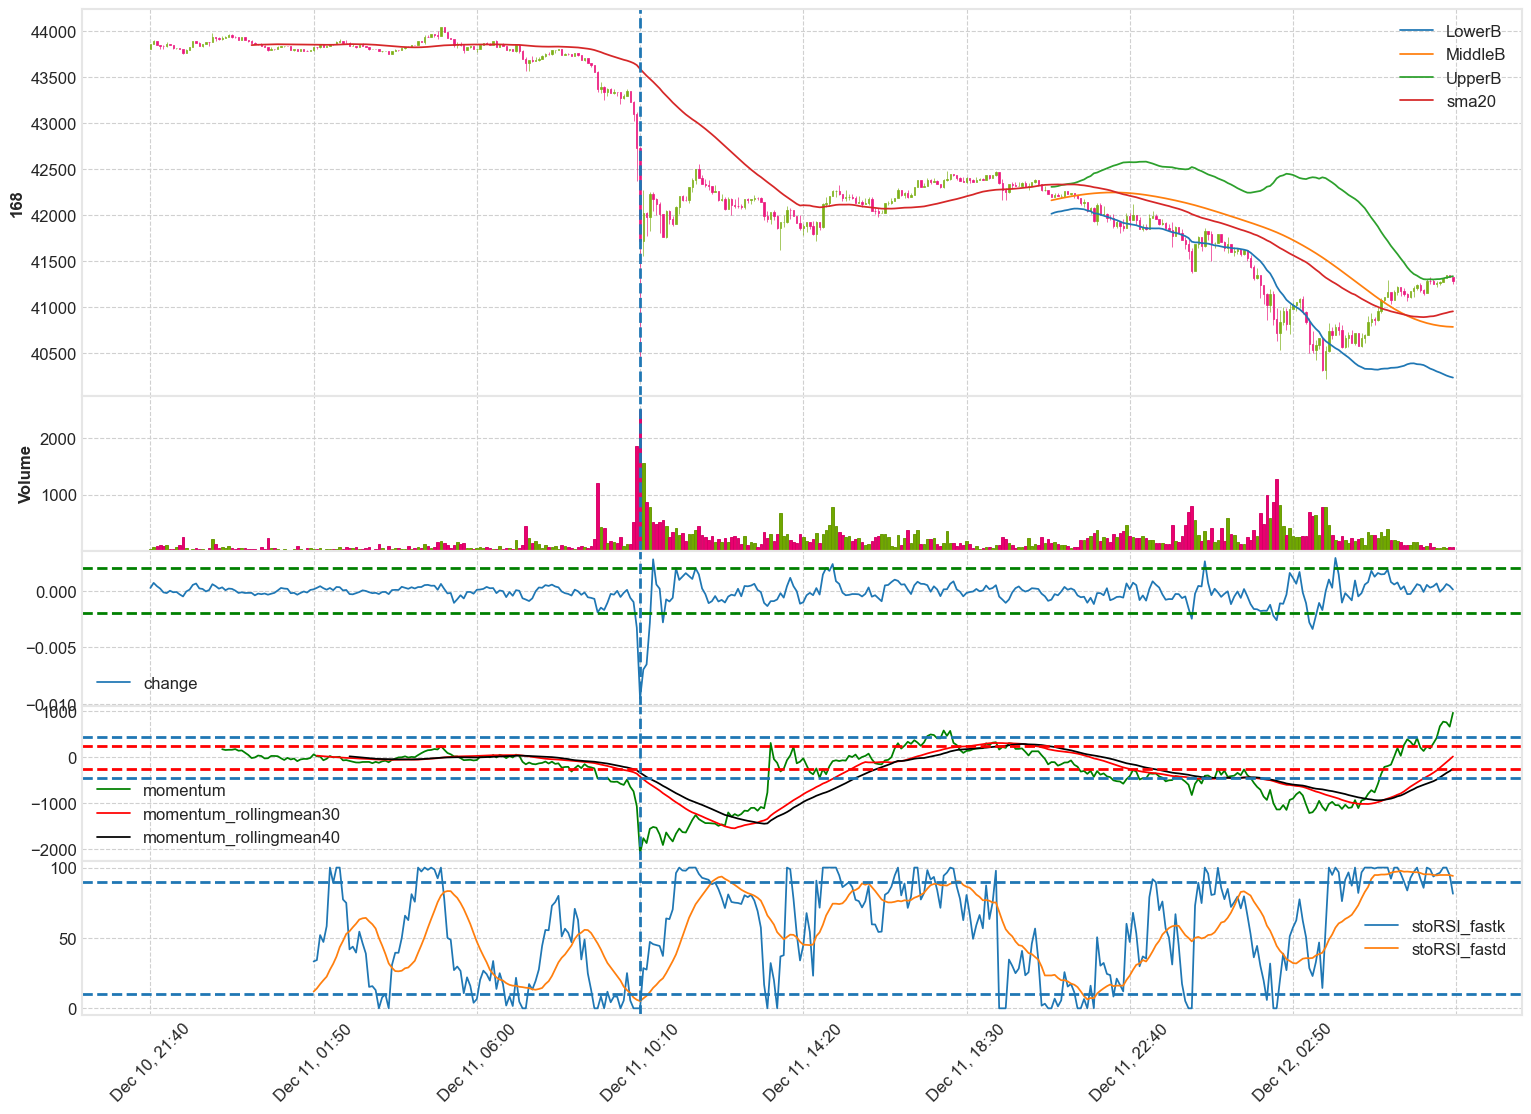

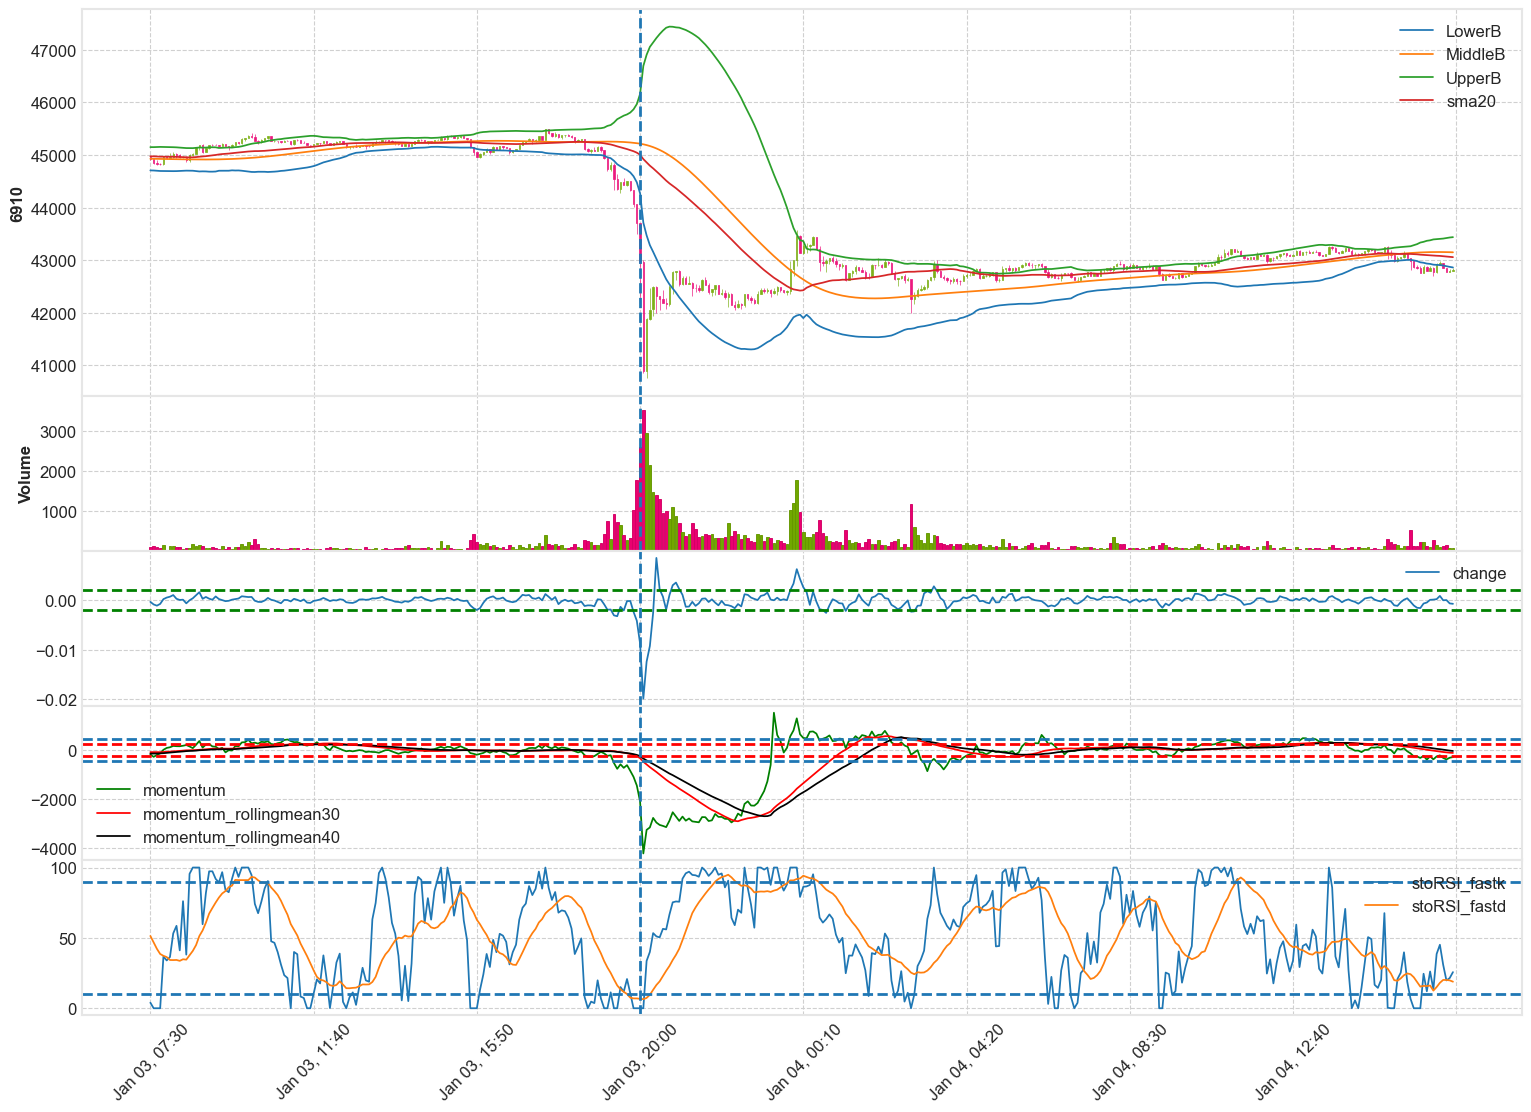

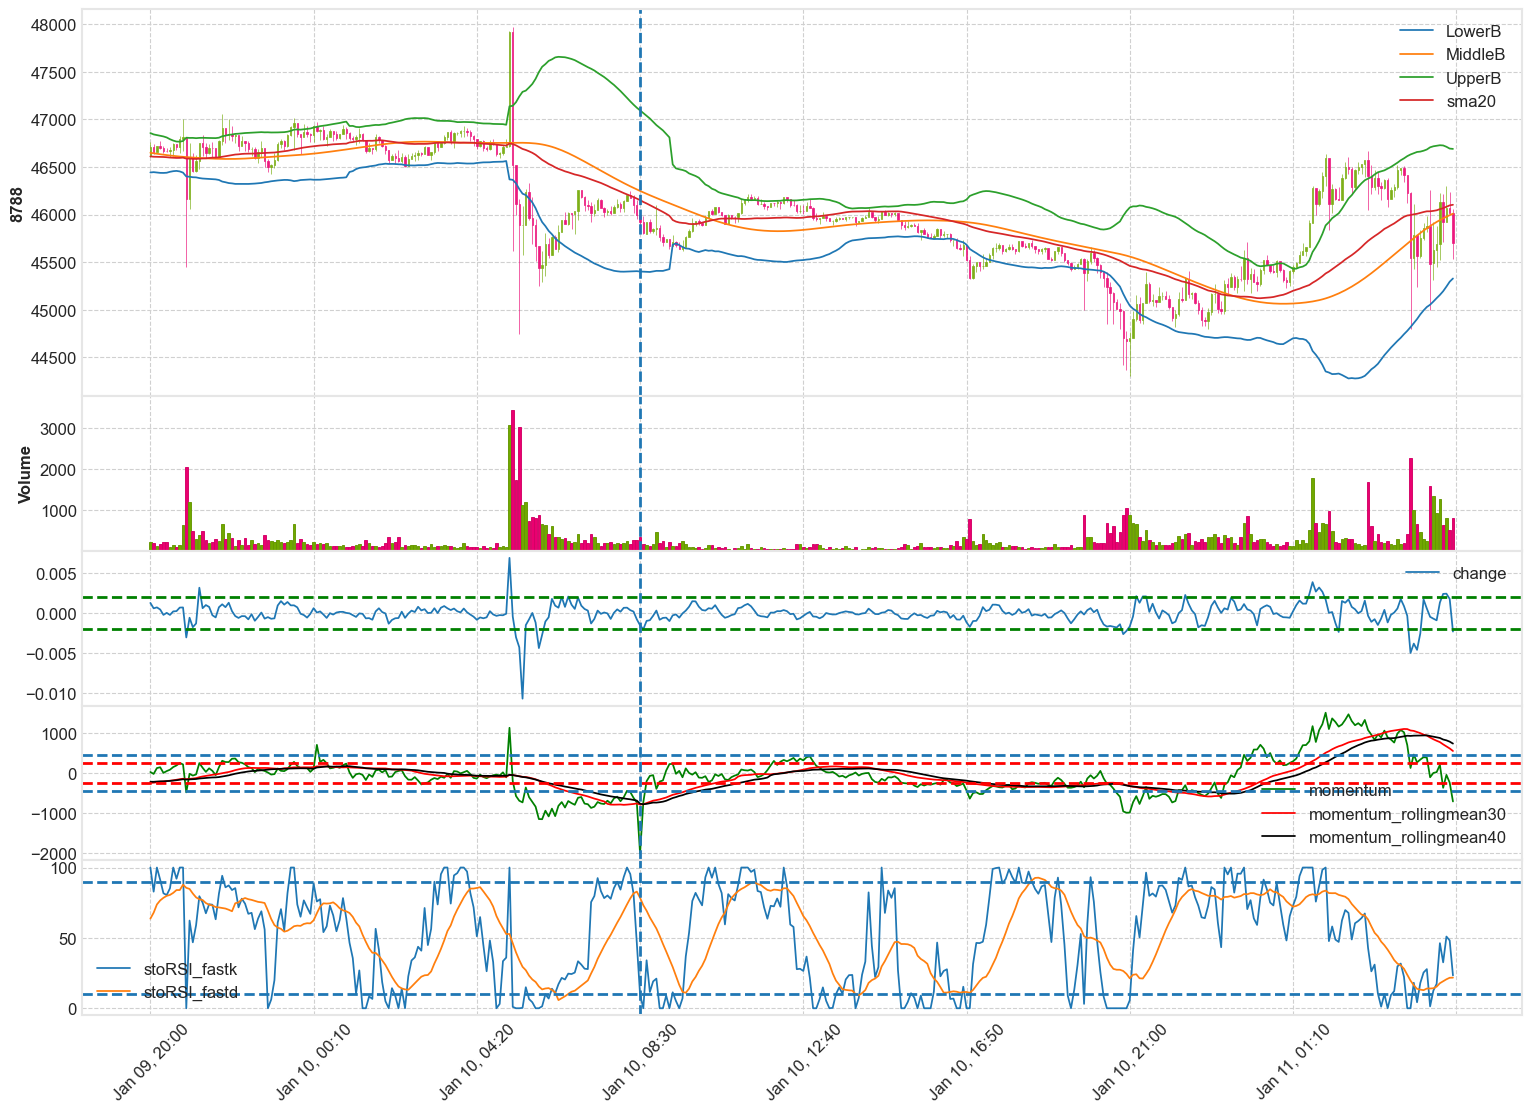

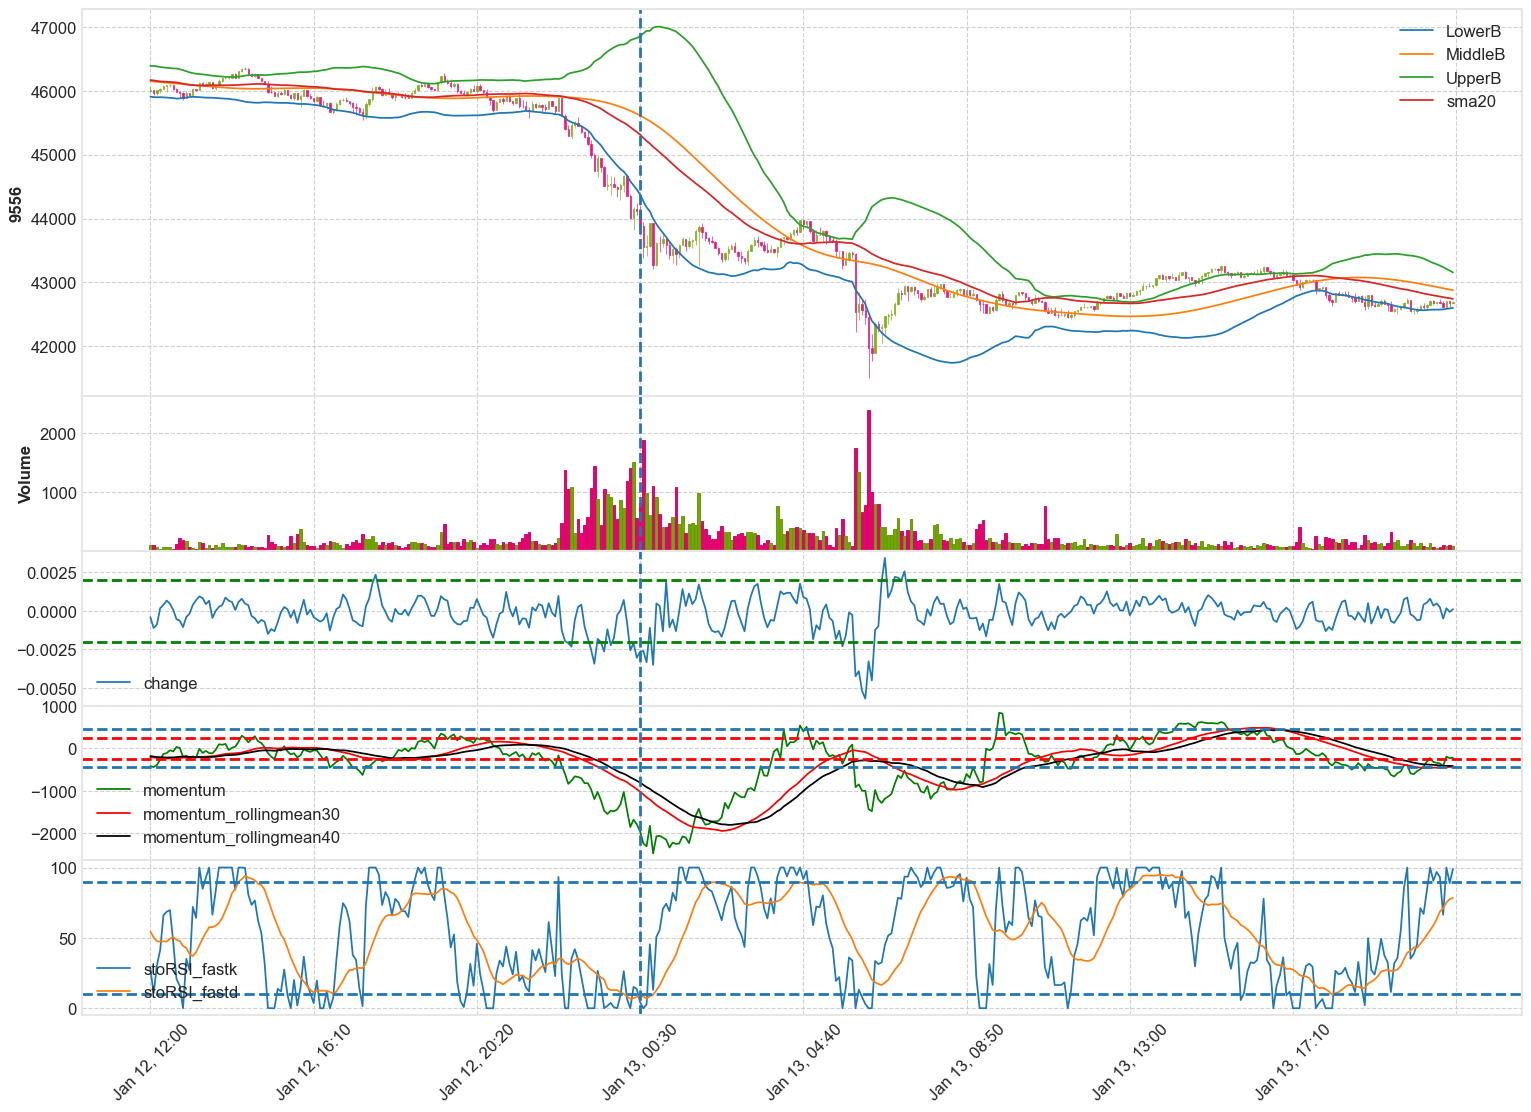

CPU times: total: 9.58 s
Wall time: 15.4 s


In [65]:
%%time
selected_indexs=potential_candidates
for inddex_of_frame in selected_indexs[:]:
    #vlines=dict(vlines=[dfmpl.iloc[inddex_of_frame].name])
    my_vlines=[dfmpl_temp.iloc[inddex_of_frame].name]
    my_vlines=[150]
    lowerlim = inddex_of_frame-150
    upperlim = lowerlim+400
    apdict = [mpf.make_addplot(lower.iloc[lowerlim:upperlim],label="LowerB"),
              mpf.make_addplot(middle.iloc[lowerlim:upperlim],label="MiddleB"),
              mpf.make_addplot(upper.iloc[lowerlim:upperlim],label="UpperB"),
             mpf.make_addplot(sma20.iloc[lowerlim:upperlim],label="sma20"),
             mpf.make_addplot(change.iloc[lowerlim:upperlim],panel=2,label="change"),
             mpf.make_addplot(momentum.iloc[lowerlim:upperlim],panel=3,label="momentum",color="g"),
             mpf.make_addplot(momentum_rolling30.iloc[lowerlim:upperlim],panel=3,label="momentum_rollingmean30",color="r",secondary_y=False),
             mpf.make_addplot(momentum_rolling40.iloc[lowerlim:upperlim],panel=3,label="momentum_rollingmean40",color="k",secondary_y=False),
             mpf.make_addplot(stoRSI_fastk.iloc[lowerlim:upperlim],panel=4,label="stoRSI_fastk"),
              mpf.make_addplot(stoRSI_fastd.iloc[lowerlim:upperlim],panel=4,label="stoRSI_fastd")
             ]
    fig, axlist = mpf.plot(dfmpl_temp.iloc[lowerlim:upperlim],type='candle',volume=True,addplot=apdict,style="binance",
             warn_too_much_data=5000000,figscale=2.5,ylabel=f"{inddex_of_frame}",
            #vlines=my_vlines,
                           returnfig=True
                       )
             #savefig=f'2_3_0_figures/testsave_{inddex_of_frame}.png')
    for axi,ax in enumerate(axlist):
        for vline in my_vlines:
            ax.axvline(x=vline, linestyle='--')
        if axi==4:
            ax.axhline(-0.002, linestyle='--',c="g")
            ax.axhline(0.002, linestyle='--',c="g")
        if axi==6:
            ax.axhline(-450, linestyle='--')
            ax.axhline(450, linestyle='--')
            ax.axhline(-250, linestyle='--',c="r")
            ax.axhline(250, linestyle='--',c="r")
        if axi==8:
            ax.axhline(90, linestyle='--')
            ax.axhline(10, linestyle='--')
    mpf.show()

In [26]:
#from plotting import plot_profits

In [27]:
#plot_profits(collated_data[:,2])